# Climate Stress Test experiment

## Introduction

Notebook for the workflow **Snakefile_climate_experiment**: 

1. extract and analyse reference historical climate with a weather generator.
2. generates future climate realizations with (transient or not) changes in mean and variance of climate variables using a weather generator.
3. run a previously built hydrological model (see **Snakefile_historical_hydrology**) with the generated realizations to perform a stress test.
4. Analyse the results

This worflow **requires to have previously run the historical_hydrology workflow** or to have an existing hydrological model. Optionnally to assist with the settings of the weather generator, it is advised to run the **climate_projections** workflow to choose realistic change factors in precipitation and temperature for your region of interest.

In [1]:
# Import some python libraries we will need to run this notebook
import os
from IPython import display

In [2]:
# A helper function
from subprocess import Popen, PIPE, STDOUT

from IPython.core.magic import register_line_magic


@register_line_magic
def runrealcmd(command):
    with Popen(
        command, stdout=PIPE, shell=True, stderr=STDOUT, bufsize=1, close_fds=True
    ) as process:
        for line in iter(process.stdout.readline, b""):
            print(line.rstrip().decode("utf-8"))

## Defining your climate stress test experiment

First thing is to prepare all the options for your project, this is done using the configuration or settings file below

In [3]:
# Add here the path where you have installed the blueearth-cst tool
cst_path = r'c:\repos\blueearth_cst'
os.chdir(cst_path)

Here we need to design our stress test experiment. This include the number of future climate realizations as well as which climate scenarios to apply to these realizations. Stress test changes can be applied on temperature (relative change) or on precipitation (multiplier).

The different settings are controlled in the configuration or settings file below:

In [4]:
%%writefile ./config/my-project-settings.yml

###########################################################################################
#################################### General setting ######################################

# Path to where the wflow model will be stored (include the project name)
project_dir: examples/myModel

# Path to the data catalog to use (can be different for Linux/Windows/data stored on P drive or other)
data_sources: 
  - artifact_data
  - tests/data/tests_data_catalog.yml

###########################################################################################
################################## Climate experiment #####################################
# Name of the experiment
experiment_name: experiment
# Reference historical climate to use for the stress test
clim_reference: era5
# Weather generator default/advanced settings file
weathergen_config: config/cst_api/weathergen_config.yml
# Number of climate realizations
realizations_num: 2
# Future Time horizon for the climate experiment
horizontime_climate: 2050
# Length of future run in years
run_length: 10
# Run historical realization
run_historical: FALSE

# Climate stress test parameters
# Temperature change factors
# including number of steps and min, max change
temp:
  step_num: 1
  transient_change: TRUE
  mean:
    min:
      - 0.0  # January
      - 0.0  # February
      - 0.0  # March
      - 0.0  # April
      - 0.0  # May
      - 0.0  # June
      - 0.0  # July
      - 0.0  # August
      - 0.0  # September
      - 0.0  # October
      - 0.0  # November
      - 0.0  # December
    max:
      - 3.0  # January
      - 3.0  # February
      - 3.0  # March
      - 3.0  # April
      - 3.0  # May
      - 3.0  # June
      - 3.0  # July
      - 3.0  # August
      - 3.0  # September
      - 3.0  # October
      - 3.0  # November
      - 3.0  # December

# Precipitation change factors
# including number of steps and min, max change
precip:
  step_num: 2
  transient_change: TRUE
  mean:
    min:
      - 0.7  # January
      - 0.7  # February
      - 0.7  # March
      - 0.7  # April
      - 0.7  # May
      - 0.7  # June
      - 0.7  # July
      - 0.7  # August
      - 0.7  # September
      - 0.7  # October
      - 0.7  # November
      - 0.7  # December
    max:
      - 1.3  # January
      - 1.3  # February
      - 1.3  # March
      - 1.3  # April
      - 1.3  # May
      - 1.3  # June
      - 1.3  # July
      - 1.3  # August
      - 1.3  # September
      - 1.3  # October
      - 1.3  # November
      - 1.3  # December
  variance:
    min:
      - 1.0  # January
      - 1.0  # February
      - 1.0  # March
      - 1.0  # April
      - 1.0  # May
      - 1.0  # June
      - 1.0  # July
      - 1.0  # August
      - 1.0  # September
      - 1.0  # October
      - 1.0  # November
      - 1.0  # December
    max:
      - 1.0  # January
      - 1.0  # February
      - 1.0  # March
      - 1.0  # April
      - 1.0  # May
      - 1.0  # June
      - 1.0  # July
      - 1.0  # August
      - 1.0  # September
      - 1.0  # October
      - 1.0  # November
      - 1.0  # December

# Runoff statistics
# Drought return period
Tlow: 2
# Flood return period
Tpeak: 10
# Aggregate realizations before computing statistics
aggregate_rlz: TRUE

Writing ./config/my-project-settings.yml


## Running the model building workflow

The workflow can be run using the snakemake command line interface.

The first line is to create an image of our workflow with snakemake to verify that all our settings are well accounted for.

In [5]:
! snakemake -s snakemake/Snakefile_climate_experiment.smk --configfile config/my-project-settings.yml --dag | dot -Tpng > dag_climate.png

Building DAG of jobs...


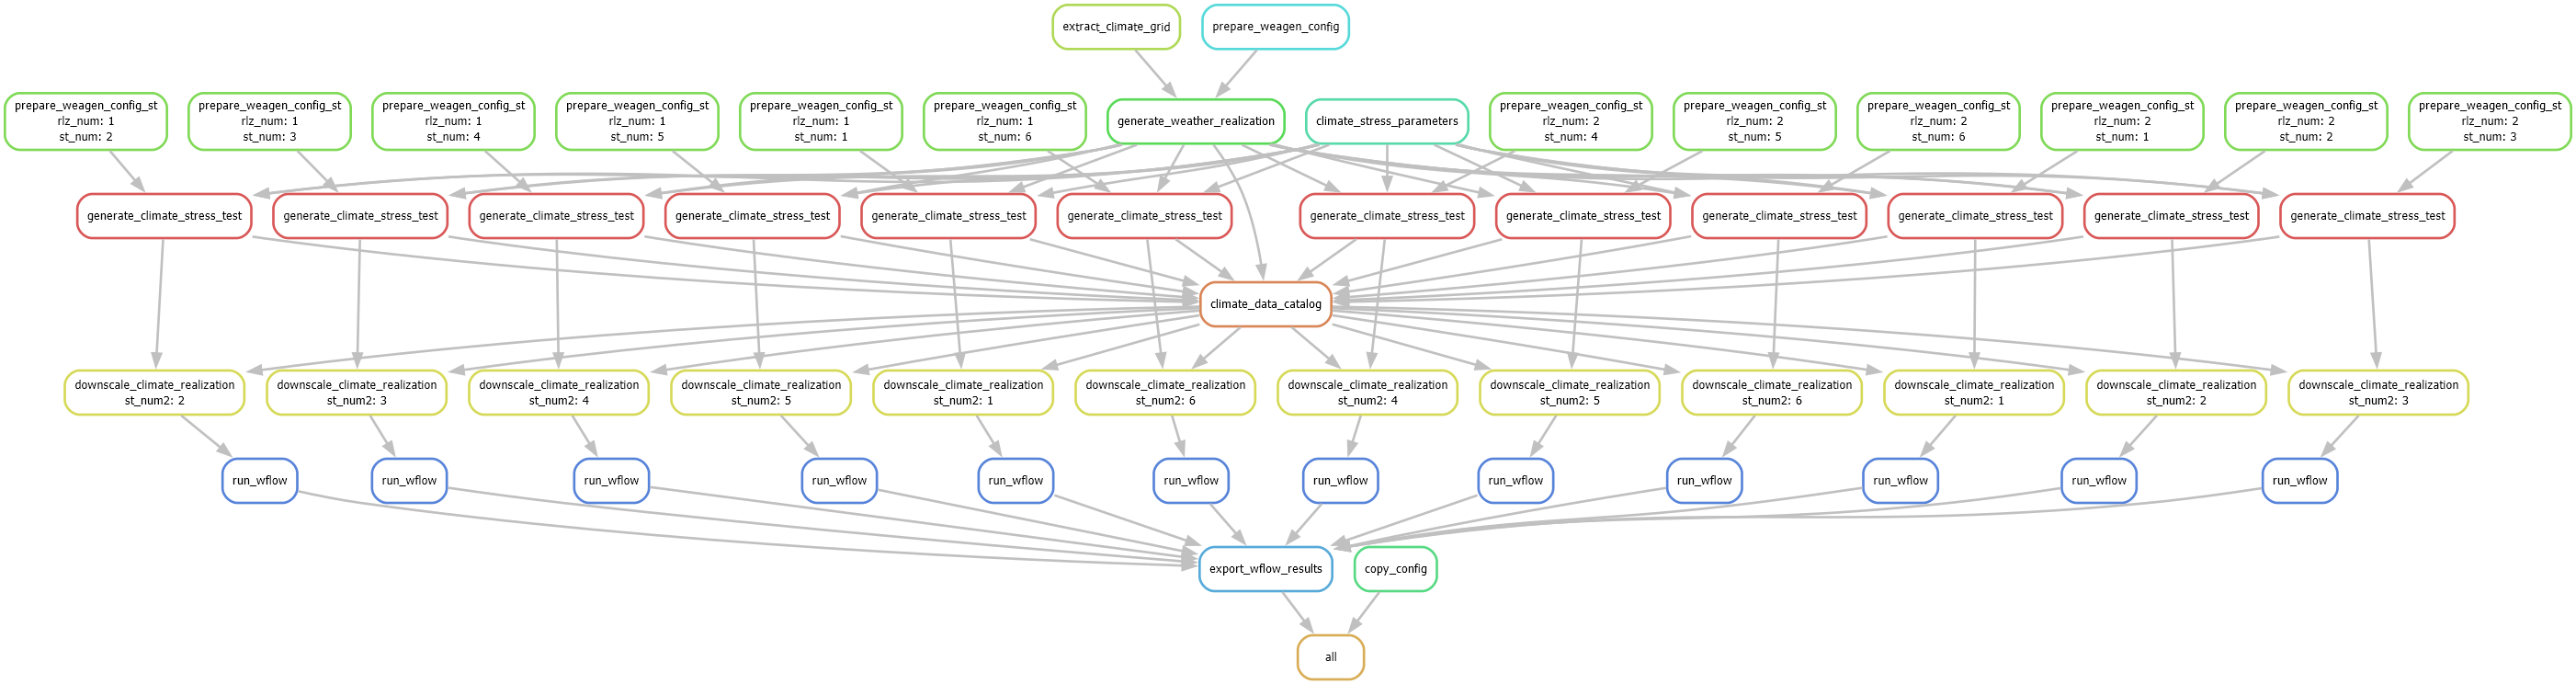

In [6]:
display.Image("./dag_climate.png")

Let's have a closer look at this diagram, which shows the subsequent rules of the snakemake workflow:

1. **extract_climate_grid**: extract the historical climate selected in ``clim_reference`` that will be used as reference by the weather generator for the region of interest.
2. **prepare_weagen_config**: prepares the settings file for the weather generator based on options provided in the snakemake config file in `realizations_num`, `horizontime_climate`, `run_length`, `precip` and `temp`.
3. **generate_weather_realization**: the weather generator analyses the reference historical climate data on produces one or several weather realization timeseries (`realizations_num`) for a number of years (specified in `run_length`) based on current climate statistics.
4. **prepare_weagen_config_st**: prepare a weather generator configuration for one particular stress test (one change in temperature and one change in precipitation).
5. **generate_climate_stress_test**: the weather generator produces a perturbed climate timeseries for a specific stress test.
6. **climate_data_catalog**: create a hydromt data catalog to reference all the perturbed climate timeseries from the different stress tests.
7. **downscale_climate_realization**: prepares forcing for the hydrological model for each stress test climate timeseries.
8. **run_wflow**: run the hydrological model with each stress test climate timeseries.
9. **export_wflow_results**: analyse the influence of each stress test climate timeseries on the hydrology.
10. **copy_config**: all configuration files are saved to make the workflow reproducible.

Now we will unlock your directory in order to save the future results of the workflow. This step is most of the time not necessary.

In [7]:
! snakemake --unlock -s snakemake/Snakefile_climate_experiment.smk --configfile config/my-project-settings.yml

Building DAG of jobs...
Unlocked working directory.


And finally let's run our worflow:

In [ ]:
%runrealcmd snakemake all -c 1 -s snakemake/Snakefile_climate_experiment.smk --configfile config/my-project-settings.yml

## Results

First check that snake did run everything.

The diagram will show dotted lines when a rule has already been performed. 

In [9]:
! snakemake -s snakemake/Snakefile_climate_experiment.smk --configfile config/my-project-settings.yml  --dag | dot -Tpng > dag_climate.png

Building DAG of jobs...


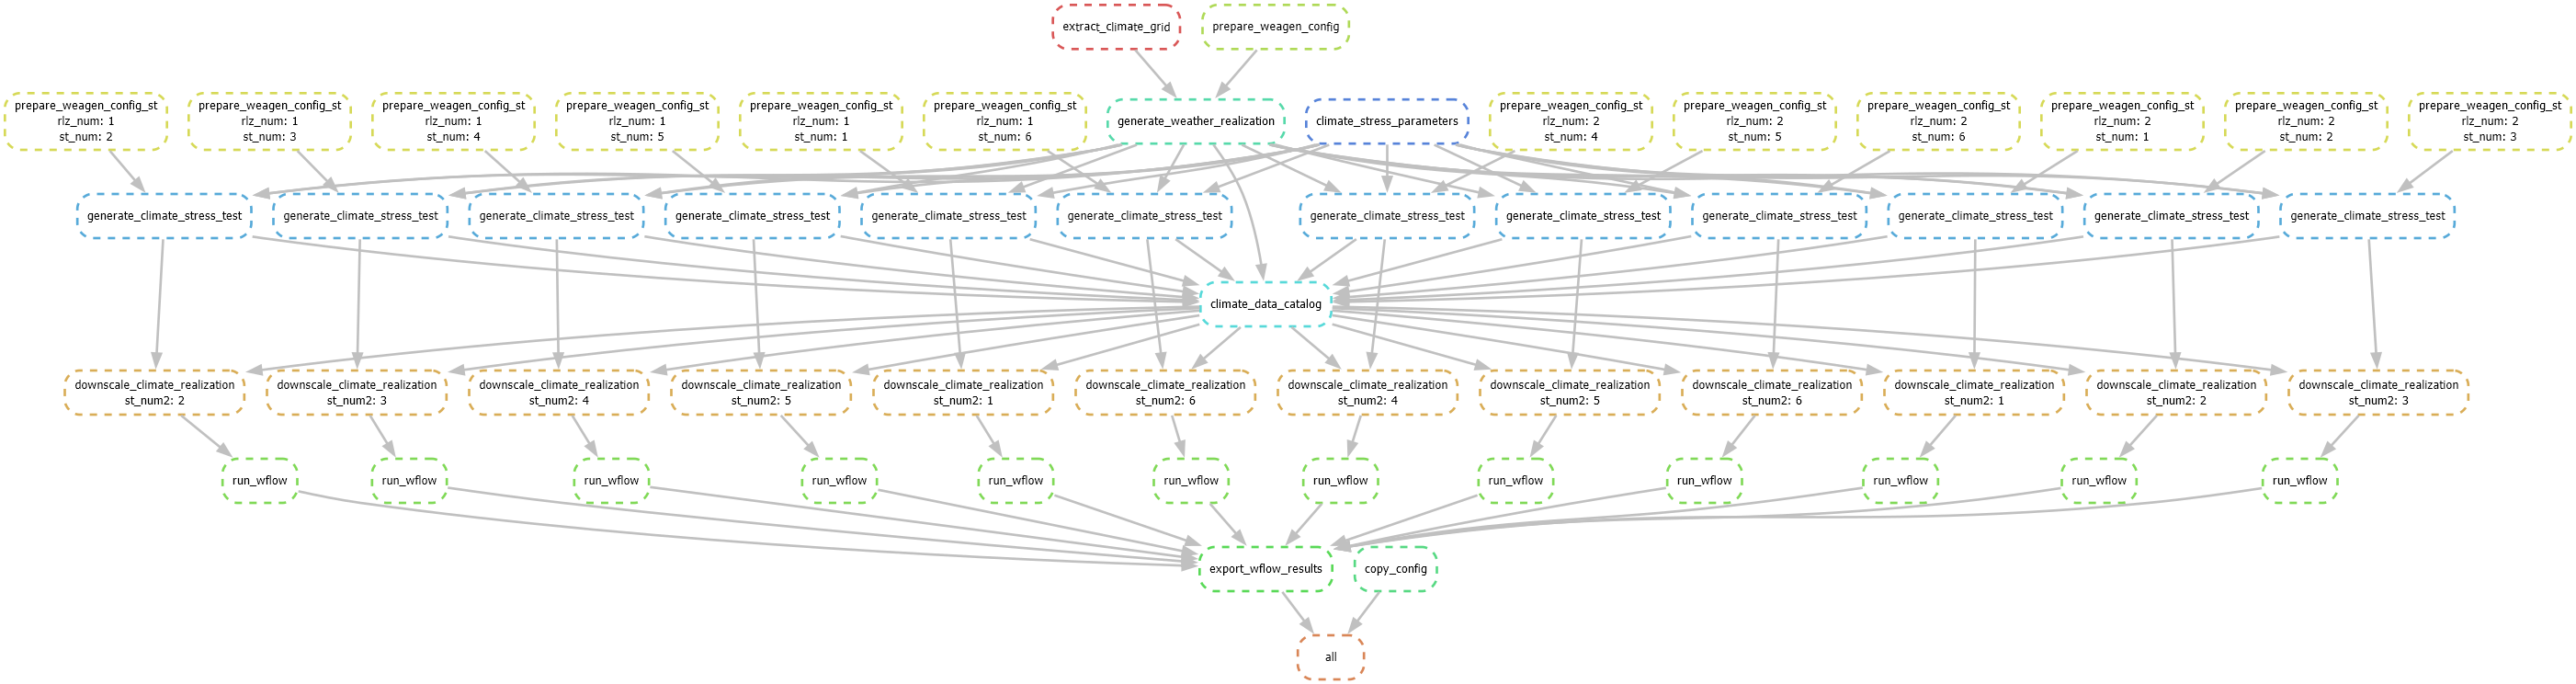

In [10]:
display.Image("./dag_climate.png")

Let's see which files where created in our output folder. The location of the output folder is defined in the config file under `project_dir`/climate_`experiment_name`. In our case, the results of this workflow are stored in the directory *examples/myModel/climate_experiment*. 

In [11]:
root = "examples/myModel/climate_experiment"
for path, _, files in os.walk(root):
    print(path)
    for name in files:
        if name.endswith(".xml"):
            continue
        print(f" - {name}")

examples/myModel/climate_experiment
 - data_catalog_climate_experiment.yml
 - resampled_dates.csv
 - sim_dates.csv
 - weathergen_config.yml
examples/myModel/climate_experiment\model_results
 - basin.csv
 - Qstats.csv
 - RT_Q_1.csv
 - RT_Q_6349400.csv
examples/myModel/climate_experiment\plots
 - warm_annual_series.png
 - warm_hist_wavelet_analysis.png
 - warm_spectral_matching.png
 - warm_spectral_sampled.png
 - warm_stats_sampled.png
examples/myModel/climate_experiment\realization_1
 - weathergen_config_rlz_1_cst_1.yml
 - weathergen_config_rlz_1_cst_2.yml
 - weathergen_config_rlz_1_cst_3.yml
 - weathergen_config_rlz_1_cst_4.yml
 - weathergen_config_rlz_1_cst_5.yml
 - weathergen_config_rlz_1_cst_6.yml
examples/myModel/climate_experiment\realization_2
 - weathergen_config_rlz_2_cst_1.yml
 - weathergen_config_rlz_2_cst_2.yml
 - weathergen_config_rlz_2_cst_3.yml
 - weathergen_config_rlz_2_cst_4.yml
 - weathergen_config_rlz_2_cst_5.yml
 - weathergen_config_rlz_2_cst_6.yml
examples/myModel/c

Most of the files created are configuration files, and a few automated plots from the weather generator analysis. The results of the stress test on the hydrology is stored in the csv files in the folder *examples/myModel/climate_experiment/model_results*. 

The first important file, *Qstats.csv* contains change in different statistics at the outlet and locations of interest (here one GRDC gauge) for each stress test (averaged over realizations). This file can be used for example to generate surface response plot (not part yet of this workflow).

In [12]:
import pandas as pd
# Read the file
pd.read_csv("examples/myModel/climate_experiment/model_results/Qstats.csv")

,statistic,tavg,prcp,Q_1,Q_6349400
0,mean,0.0,-30.0,12.5200,4.4600
1,mean,0.0,0.0,33.8900,12.2900
2,mean,0.0,30.0,57.8100,21.2200
3,mean,3.0,-30.0,11.9300,4.2700
4,mean,3.0,0.0,32.4900,11.7500
...,...,...,...,...,...
61,BaseFlowIndex,0.0,0.0,0.3002,0.3028
62,BaseFlowIndex,0.0,30.0,0.2337,0.2305
63,BaseFlowIndex,3.0,-30.0,0.5364,0.4357
64,BaseFlowIndex,3.0,0.0,0.3968,0.4137


Similar results are also availale for other variables than discharge averaged over the whole hydrological model domain, for example actual evapotranspiration. These are in the *basin.csv* file.

In [13]:
pd.read_csv("examples/myModel/climate_experiment/model_results/basin.csv")

,tavg,prcp,precipitation_basavg,overland flow_basavg,actual evapotranspiration_basavg,groundwater recharge_basavg,snow_basavg,glacier_basavg
0,0.0,-30.0,899.2,5.3,456.0,399.5,115.5,44025.3
1,0.0,0.0,1794.2,33.6,532.0,1076.7,233.6,46506.0
2,0.0,30.0,2713.1,87.0,544.7,1707.8,374.1,48973.7
3,3.0,-30.0,899.2,4.7,480.5,380.6,13.8,20286.3
4,3.0,0.0,1794.2,27.6,588.2,1057.2,34.3,20519.5
5,3.0,30.0,2713.1,73.9,606.8,1736.2,71.2,20834.9
